In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from keras.regularizers import l2
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import SeparableConv2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
import tensorflow

In [14]:
X = np.load('../downloads/all/X.npy') # images
Y = np.load('../downloads/all/Y.npy') # labels associated to images (0 = no IDC, 1 = IDC)

In [15]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X,Y)

Total number of images: 5547
Number of IDC(-) Images: 2759
Number of IDC(+) Images: 2788
Percentage of positive images: 50.26%
Image shape (Width, Height, Channels): (50, 50, 3)


In [16]:
X_train=X
Y_train=Y
X_train = X_train / 256.0


In [17]:
type(Y_train)

numpy.ndarray

In [18]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(Y_train)


In [19]:
img_rows, img_cols = X_train.shape[1],X_train.shape[2]
input_shape = (img_rows, img_cols, 3)

In [20]:
type(img_rows)
type(img_cols)
type(input_shape)

tuple

In [23]:
model = Sequential()
model.add(SeparableConv2D(32, (3, 3), activation='elu', kernel_initializer='he_uniform',input_shape=input_shape,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(SeparableConv2D(64, (3, 3), activation='elu', kernel_initializer='he_uniform',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(SeparableConv2D(64, (3, 3), activation='elu', kernel_initializer='he_uniform',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(SeparableConv2D(128, (3, 3), activation='elu', kernel_initializer='he_uniform',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(SeparableConv2D(128, (3, 3), activation='elu', kernel_initializer='he_uniform',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='elu', kernel_initializer='he_uniform',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
# compile model
opt =SGD(lr=0.01,momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
scores=list()
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True)
for train_ix, test_ix in skf.split(X_train,Y_train):
   # select rows for train and test
   trainX, trainY, testX, testY = X_train[train_ix], Y_train[train_ix],X_train[test_ix], Y_train[test_ix]
   trainY = to_categorical(trainY, num_classes = 2)
   testY = to_categorical(testY, num_classes = 2)
   # fit model
   model.fit(trainX, trainY, epochs=12, batch_size=32, validation_data=(testX, testY), verbose=0)
   # evaluate model
   _, acc = model.evaluate(testX, testY, verbose=0)
   print('> %.3f' % (acc * 100.0))
   # stores scores
   scores.append(acc)
print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))


> 89.009
> 90.991
> 91.892
> 93.153
> 93.153
> 81.441
> 90.270
> 95.135
> 87.365
> 84.991
Accuracy: mean=89.740 std=3.956, n=10


In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix
import itertools
score = model.evaluate(testX, testY, verbose=0)
print('\nKeras CNN #1A - accuracy:', score[1],'\n')
y_pred = model.predict(testX) 
map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
print('\n', sklearn.metrics.classification_report(np.where(testY > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(testY,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values())) 



TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.engine.sequential.Sequential object at 0x1a4a4468d0> does not.

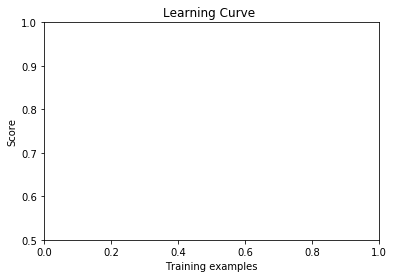

In [11]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Plots a learning curve. http://scikit-learn.org/stable/modules/learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt
plot_learning_curve(model, 'Learning Curve ',X_train, Y_train , (0.5,1), 10)


